<a href="https://colab.research.google.com/github/Emio-eng/web-scraper/blob/main/Raspagem_de_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Primeiro passo: Definir o que você quer extrair: Informações sobre Hostel's

Aqui iremos extrair:

Nome do hostel

Link para a página do hostel

Distância do hostel até o centro da cidade

Nota média de avaliação

Número de avalições feitas para aquele local

Preço médio por noite, em USD

##Instalando bibliotecas que serão usadas

In [ ]:
 !pip install requests
 !pip install beautifulsoup4

In [ ]:
from requests import get
## O BeautifulSoup precisa ter o módulo bs4 chamado, pois os módulos anteriores foram encerrados.
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import time
import re

url = 'https://www.hostelworld.com/hostels/Berlin'
response = get(url)

# criando soup
soup = BeautifulSoup(response.text, 'html.parser')
# Aqui estamos formatando as informações que vão ficar do get(url) acima

# criação de containers individuais, em cada um há informações sobre um hostel.
holstel_containers= soup.findAll(class_= 'fabresult rounded clearfix hwta-property')

# quantos hostels na página
len(holstel_containers)

30

##Separar um hostel para descobrir os atributos de acesso necessários

Todos os contêineres contém a mesma estrutura, e o que muda, logicamente, é a informação armazenada dentro de cada um. Para facilitar a análise, iremos criar um objeto apenas com a informação do primeiro hostel, e depois iremos explorar esse container para descobrir onde estão os dados que desejamos. No exemplo abaixo, temos o código que detém as informações do Hostel.

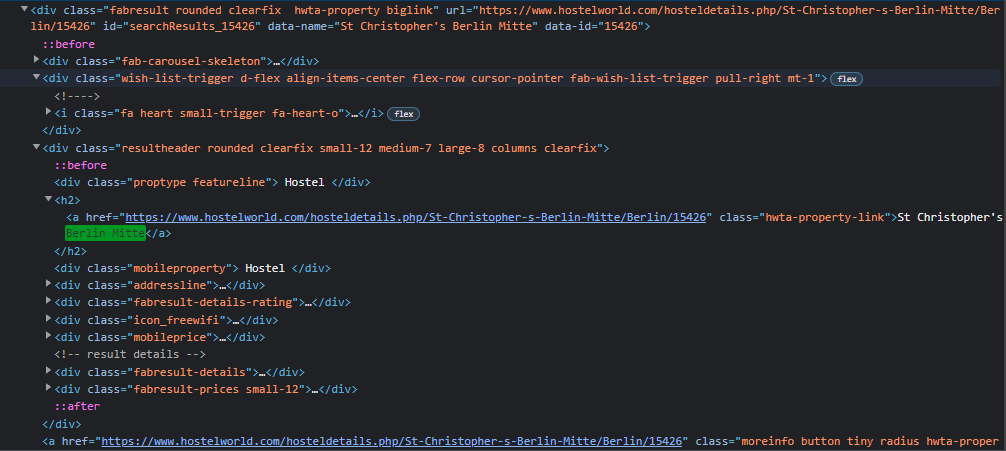

Para agilizar o processo, tirei print do corpo HTML que cita o nome do primeiro hostel catalogado no site; e abaixo na célula do código, podemos ver que a raspagem está funcionando corretamente

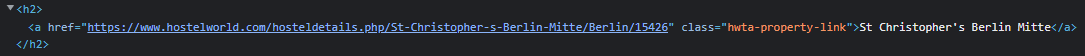

In [ ]:
first_hostel = holstel_containers[0]

# Nome do Hostel
first_hostel.h2.a.text

"St Christopher's Berlin Mitte"

Acessei o primeiro header ‘h2’, depois selecionei a tag ‘a’, e então extraí apenas o texto.

In [ ]:
print(first_hostel.prettify())
# Aqui teremos todo o código html do primeiro hotel

##Como fazer com todos os 30 hostels?

Daí foi só ver quantas páginas com opções de hostel haviam disponíveis, nesse caso eram 2. A solução pensada foi criar dois for loops, um para entrar em cada página e separar cada hostel em um contêiner, e outro para retirar de cada contêiner os dados, para então armazenar o resultado em listas.

In [ ]:
# primeiro, crie as listas vazias
hostel_names= []
hostel_links= []
hostel_distance= []
hostel_ratings= []
hostel_reviews= []
hostel_prices= []

for page in np.arange(1,4): # para iterar nas páginas e criar os contêineres
  url = 'https://www.hostelworld.com/hostels/Berlin?page=' + str(page)
  response = get(url)
  soup = BeautifulSoup(response.text, 'html.parser')
  holstel_containers= soup.findAll(class_= 'fabresult rounded clearfix hwta-property')

  for item in range(len(holstel_containers)): # para iterar sobre os resultados em cada página
    hostel_names.append(holstel_containers[item].h2.a.text) ##nome do hostel
    hostel_links.append(holstel_containers[item].h2.a.get('href')) ##link do hostel
    hostel_distance.append(holstel_containers[item].find(class_= "addressline").text[12:18].replace('k','').replace('m','').strip()) ##distancia do hostel
    hostel_ratings.append(holstel_containers[item].find(class_='hwta-rating-score').text.replace('\n', '').strip()) ## nota média de avaliação
    hostel_reviews.append(holstel_containers[item].find(class_="hwta-rating-counter").text.replace('\n', '').strip()) ## Número de avalições feitas para aquele local
    hostel_prices.append(holstel_containers[item].find(class_= "price").text.replace('\n', '').strip()[3:]) ## Preço médio por noite, em USD
  time.sleep(2) # isso é usado para não forçar muito no site, para não acharem que foi um ataque

Os comandos mais importantes para se entender inicialmente são findAll(), find() e get(). É com eles que você vai conseguir extrair quase tudo em um projeto de raspagem de dados;

strip() e replace() foram utilizados. Fiz isso para conseguir retirar letras e espaços indesejados. Usar várias técnicas de pré processamento é recomendado para deixar os dados fáceis de se manusear.
O strip() foi utilizado para retirar os espaços em branco no começo e no final dos valores. Já o replace() foi utilizado para remover letras

##Hora de criar a tabela

In [ ]:
hw_berlin = pd.DataFrame({
    'hostel_name': hostel_names,
    'distance_centre_km': hostel_distance,
    'average_rating': hostel_ratings,
    'number_reviews': hostel_reviews,
    'average_price_usd': hostel_prices,
    'hw_link': hostel_links
})

##Mostrando as 5 primeiras entradas do dataframe

In [ ]:
hw_berlin.head()

,hostel_name,distance_centre_km,average_rating,number_reviews,average_price_usd,hw_link
0,Lettem Sleep,2.4,7.0,1278,14.80,https://www.hostelworld.com/hosteldetails.php/...
1,BIG MAMA Berlin,4.5,8.3,54,24.96,https://www.hostelworld.com/hosteldetails.php/...
2,Metropol Hostel Berlin,3.5,6.4,1295,19.44,https://www.hostelworld.com/hosteldetails.php/...
3,Nena Hostel Berlin,5 fr,7.8,30,22.69,https://www.hostelworld.com/hosteldetails.php/...
4,Eastern & Western Comfort Hostelboats,3.2,8.7,1060,16.15,https://www.hostelworld.com/hosteldetails.php/...


O distance_centre_km na linha 3 está contando com as letras 'fr', onde deveria ser apenas um número

##Podemos tratar isso com um REGEX!




A palavra vem de Regular Expressions, e é uma ferramenta extremamente poderosa para filtrar texto a partir de padrões pré definidos e altamente customizáveis. Mas as expressões são difíceis, e é demorado até se aprender totalmente

Nessa tratativa vamos usar a função sub(), que é uma função para substituir.
Vamos criar uma compreensão de lista que retorna todas as linhas da coluna distance_centre_km.
A cada linha que retornar usaremos a expressão regular '[^ 0-9]', que irá excluir tudo que não seja número ou ponto.

In [ ]:
# removendo caractere não numérico na coluna distance_centre_km

hw_berlin.distance_centre_km = [re.sub('[^0-9.]','', x) for x in hw_berlin.distance_centre_km]

##Testando novamente as 5 primeiras entradas após a aplicação do REGEX

In [ ]:
hw_berlin.head()

,hostel_name,distance_centre_km,average_rating,number_reviews,average_price_usd,hw_link
0,Lettem Sleep,2.4,7.0,1278,14.80,https://www.hostelworld.com/hosteldetails.php/...
1,BIG MAMA Berlin,4.5,8.3,54,24.96,https://www.hostelworld.com/hosteldetails.php/...
2,Metropol Hostel Berlin,3.5,6.4,1295,19.44,https://www.hostelworld.com/hosteldetails.php/...
3,Nena Hostel Berlin,5,7.8,30,22.69,https://www.hostelworld.com/hosteldetails.php/...
4,Eastern & Western Comfort Hostelboats,3.2,8.7,1060,16.15,https://www.hostelworld.com/hosteldetails.php/...
